In [2]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data.ee import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
from src.constants import DATA_PATH, USER_PATH
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot
from src.data import pai_vertical
sns.set_theme()

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-26 23:42:29,031 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [3]:
def get_matches(df, distance):
    return df[df.closest_distance < distance]

def get_severity(df, severity):
    return df[df.severity == severity]

In [4]:
sierras_complex = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

In [5]:
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2019', '2020', '2021', '2022']).filter_within_geometry(sierras)

In [6]:
castle = sierra_firep.get_fire('CASTLE')
creek = sierra_firep.get_fire('CREEK')
knp = sierra_firep.get_fire('KNP Complex')
north = sierra_firep.get_fire('NORTH COMPLEX')
windy = sierra_firep.get_fire('WINDY')

In [7]:
gedi_burned_2x2, gedi_unburned_2x2 = gedi_pipeline.load_stage_4(2)
gedi_burned_3x3, gedi_unburned_3x3 = gedi_pipeline.load_stage_4(3)

In [8]:
castle_matches = gedi_matching.match_measurements_before_and_after_fire(castle, gedi_burned_2x2, 'agbd')
creek_matches = gedi_matching.match_measurements_before_and_after_fire(creek, gedi_burned_2x2, 'agbd')
knp_matches = gedi_matching.match_measurements_before_and_after_fire(knp, gedi_burned_2x2, 'agbd')
north_matches = gedi_matching.match_measurements_before_and_after_fire(north, gedi_burned_2x2, 'agbd')
windy_matches = gedi_matching.match_measurements_before_and_after_fire(windy, gedi_burned_2x2, 'agbd')

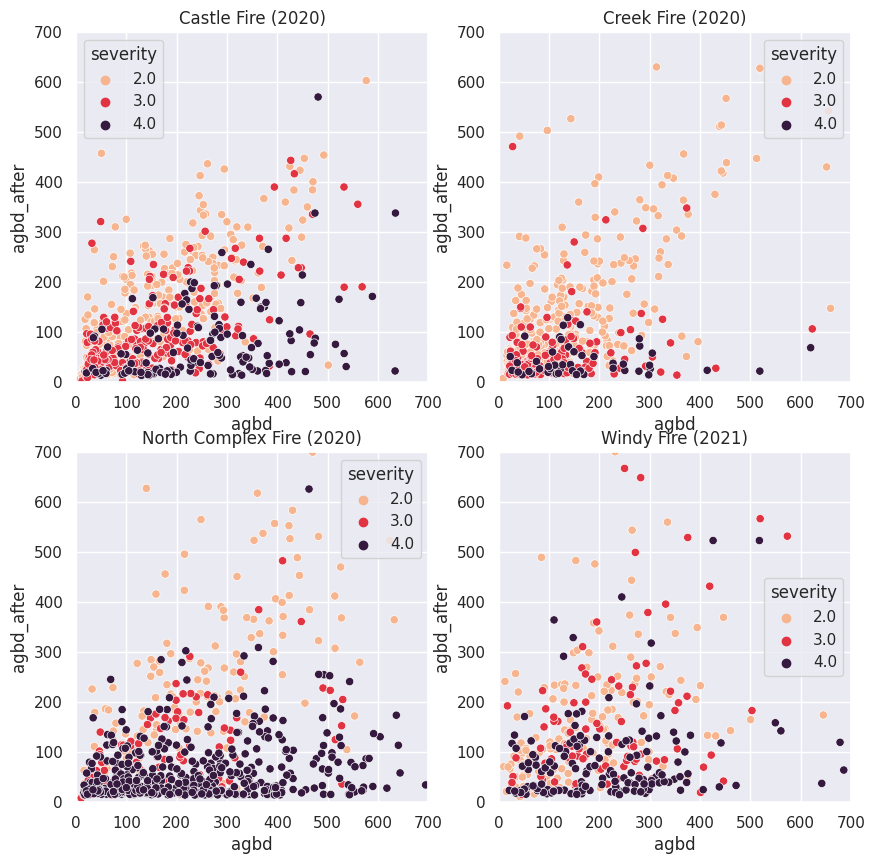

In [12]:
palette = [sns.color_palette("rocket")[i] for i in [5, 3, 0]]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

hue = 'severity'
#df = df.sort_values(hue, ascending=True)
#df = df[df.severity.isin([2, 3, 4])]

sns.scatterplot(get_matches(castle_matches, 10), x="agbd", y=f'agbd_after', hue=hue, ax=ax[0][0], palette=palette)
sns.scatterplot(get_matches(creek_matches, 10), x="agbd", y=f'agbd_after', hue=hue, ax=ax[0][1], palette=palette)
sns.scatterplot(get_matches(north_matches, 10), x="agbd", y=f'agbd_after', hue=hue, ax=ax[1][0], palette=palette)
sns.scatterplot(get_matches(windy_matches, 10), x="agbd", y=f'agbd_after', hue=hue, ax=ax[1][1], palette=palette)

ax[0][0].set_title("Castle Fire (2020)")
ax[0][1].set_title("Creek Fire (2020)")
ax[1][0].set_title("North Complex Fire (2020)")
ax[1][1].set_title("Windy Fire (2021)")

lim=700
for i in [0, 1]:
    for j in [0, 1]:
        ax[i][j].set_xlim((0, lim))
        ax[i][j].set_ylim((0, lim))

'\nlim=700\nfor i in [0, 1]:\n    for j in [0, 1]:\n        ax[i][j].set_xlim((0, lim))\n        ax[i][j].set_ylim((0, lim))\n        '

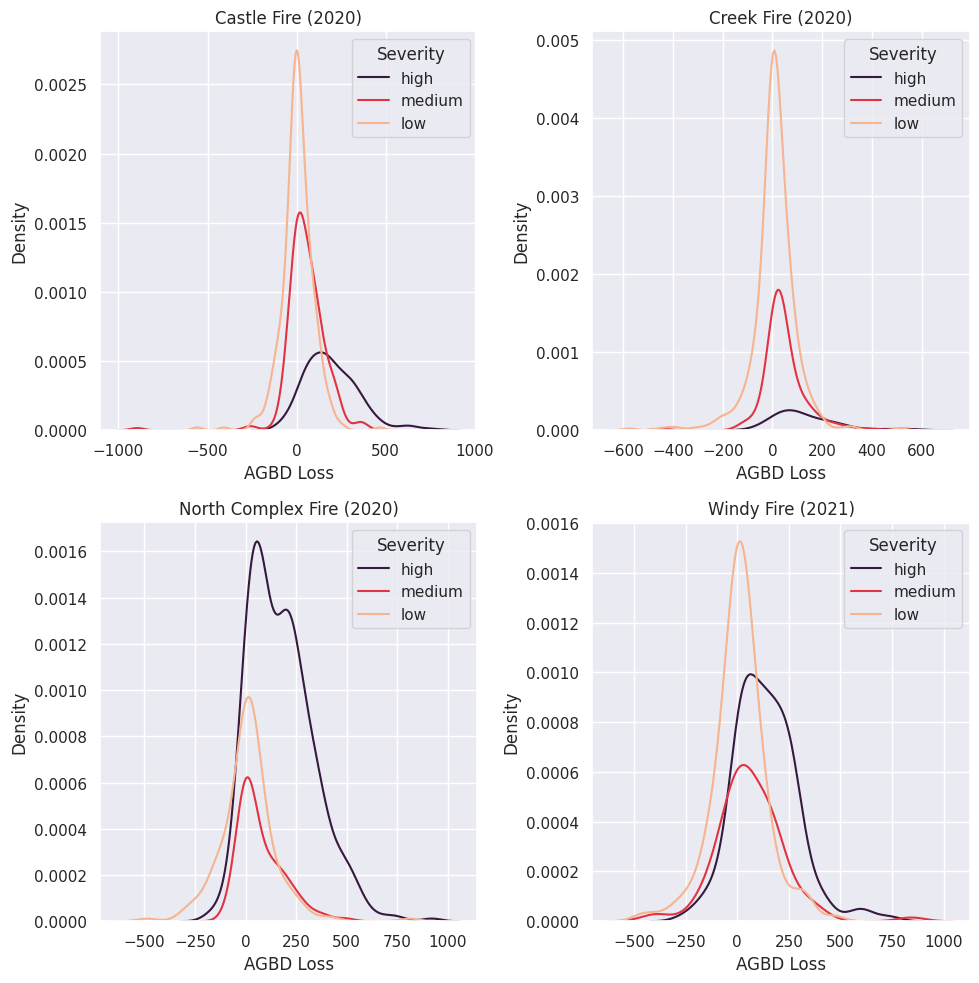

In [20]:
palette = [sns.color_palette("rocket")[i] for i in [5, 3, 0]]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

hue = 'severity'
#df = df.sort_values(hue, ascending=True)
#df = df[df.severity.isin([2, 3, 4])]

sns.kdeplot(get_matches(castle_matches, 10), x="agbd_diff", hue=hue, ax=ax[0][0], palette=palette)
sns.kdeplot(get_matches(creek_matches, 10), x="agbd_diff", hue=hue, ax=ax[0][1], palette=palette)
sns.kdeplot(get_matches(north_matches, 10), x="agbd_diff", hue=hue, ax=ax[1][0], palette=palette)
sns.kdeplot(get_matches(windy_matches, 10), x="agbd_diff", hue=hue, ax=ax[1][1], palette=palette)

ax[0][0].set_title("Castle Fire (2020)")
ax[0][1].set_title("Creek Fire (2020)")
ax[1][0].set_title("North Complex Fire (2020)")
ax[1][1].set_title("Windy Fire (2021)")

ax[0][0].set_xlabel('AGBD Loss')
ax[0][1].set_xlabel('AGBD Loss')
ax[1][0].set_xlabel('AGBD Loss')
ax[1][1].set_xlabel('AGBD Loss')

ax[0][0].legend(['high', 'medium', 'low'], title="Severity")
ax[0][1].legend(['high', 'medium', 'low'], title="Severity")
ax[1][0].legend(['high', 'medium', 'low'], title="Severity")
ax[1][1].legend(['high', 'medium', 'low'], title="Severity")

fig.tight_layout()
'''
lim=700
for i in [0, 1]:
    for j in [0, 1]:
        ax[i][j].set_xlim((0, lim))
        ax[i][j].set_ylim((0, lim))
        '''

In [9]:
matching_analysis.two_sided_tests(get_severity(get_matches(castle_matches, 10), 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9170508980751038, pvalue=4.069825206010069e-12)
Ttest results: TtestResult(statistic=1.1572349498253232, pvalue=0.24806441853966968, df=311)
Wilcoxon test results: WilcoxonResult(statistic=21686.0, pvalue=0.08714621539540193)


In [10]:
matching_analysis.two_sided_tests(get_severity(get_matches(castle_matches, 10), 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8059011697769165, pvalue=4.531424568089942e-16)
Ttest results: TtestResult(statistic=7.3648616538421, pvalue=3.322217042108542e-12, df=225)
Wilcoxon test results: WilcoxonResult(statistic=4339.0, pvalue=6.4551558361782165e-18)


In [11]:
matching_analysis.two_sided_tests(get_severity(get_matches(castle_matches, 10), 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9546430110931396, pvalue=0.00013668269093614072)
Ttest results: TtestResult(statistic=15.525156753313771, pvalue=3.073029627269811e-32, df=140)
Wilcoxon test results: WilcoxonResult(statistic=137.0, pvalue=1.2490677861900688e-23)


In [23]:
matching_analysis.two_sided_tests(get_severity(get_matches(creek_matches, 10), 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8559150099754333, pvalue=5.686872527415747e-20)
Ttest results: TtestResult(statistic=1.6147120455264374, pvalue=0.10707087384242991, df=452)
Wilcoxon test results: WilcoxonResult(statistic=40824.0, pvalue=0.00014521380364439915)


In [13]:
matching_analysis.two_sided_tests(get_severity(get_matches(creek_matches, 10), 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


In [24]:
matching_analysis.two_sided_tests(get_severity(get_matches(north_matches, 10), 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9056131839752197, pvalue=4.37699299027372e-09)
Ttest results: TtestResult(statistic=1.230530305773751, pvalue=0.2201787822396278, df=172)
Wilcoxon test results: WilcoxonResult(statistic=6498.0, pvalue=0.11935438747612585)


In [15]:
matching_analysis.two_sided_tests(get_severity(get_matches(north_matches, 10), 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9574099779129028, pvalue=3.5551189769833513e-10)
Ttest results: TtestResult(statistic=23.519692148092158, pvalue=1.5972707928362213e-80, df=453)
Wilcoxon test results: WilcoxonResult(statistic=3276.0, pvalue=5.4438032888164836e-67)


In [25]:
matching_analysis.two_sided_tests(get_severity(get_matches(windy_matches, 10), 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9532440304756165, pvalue=4.605712092597969e-05)
Ttest results: TtestResult(statistic=1.2073020999157795, pvalue=0.22916685301926326, df=154)
Wilcoxon test results: WilcoxonResult(statistic=5166.0, pvalue=0.11634237255886391)


In [17]:
matching_analysis.two_sided_tests(get_severity(get_matches(windy_matches, 10), 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9613006711006165, pvalue=0.0003069767844863236)
Ttest results: TtestResult(statistic=11.116892858780197, pvalue=2.5539834778746883e-21, df=150)
Wilcoxon test results: WilcoxonResult(statistic=899.0, pvalue=2.4863265632206056e-19)
